In [2]:
import xarray
import matplotlib.pyplot as plt
import numpy
import pandas

%matplotlib inline

In [64]:
#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.overlapBins as overlapBins
import utils.compound as compound

%run helpers/impactPlots.ipynb



In [3]:
import warnings
warnings.filterwarnings('ignore')

In [63]:
prXr=xarray.open_dataset('results/cmip6PrXr.nc')
detrendTsXr=xarray.open_dataset('results/cmip6DetrendTsXr.nc')


# Find events in the e and c indeces

 1 sigma above/below mean
Using a piControl climatology

In [4]:
ecXr=xarray.open_dataset('results/cmip6EcIndex.nc')

piControlEcXr=ecXr.sel(experiment='piControl', drop=True)


# This should calculate stds for all experiments and all indeces
stdEcXr = piControlEcXr.std(dim='year')
stdEcXr

<xarray.Dataset>
Dimensions:  (model: 37)
Coordinates:
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    eIndex   (model) float64 0.6339 0.8717 0.6902 0.6543 ... 0.7986 0.75 0.7068
    cIndex   (model) float64 0.962 0.8771 0.8874 0.8806 ... 0.841 0.8212 0.8975

Apply the 1 sigma criteria

In [9]:
ecDetrendXr=ecXr-ecXr.rolling(year=11,min_periods=5,center=True).mean('year')

In [10]:
firePosEc, fireNegEc = compound.applyCriteria(ecDetrendXr, stdEcXr)

firePos: 
['cIndex', 'eIndex']
fireNeg: 
[]


In [11]:
# find where either index is saying there is an event
# this is a bit messy, you need to make sure Nan years stay as Nan (years for the piControl is different for all the models)

firePosEc['ecCombined']=(((firePosEc.cIndex+firePosEc.eIndex)>0)*1).where(
        firePosEc.cIndex.isnull()==False)
fireNegEc['ecCombined']=(((fireNegEc.cIndex+fireNegEc.eIndex)>0)*1).where(
    fireNegEc.cIndex.isnull()==False)


In [7]:
#Find events in the trad indeces

In [13]:
tradIndecesXr = xarray.concat([
    xarray.open_dataset('results/cmip6'+experiment+'TradIndecesTos.nc') for experiment in ['piControl','ssp585']], 
'experiment')

tradIndecesXr['experiment']=['piControl','ssp585']



In [40]:
indecesList=['dmiRollingDetrend','samWinter','samSummer']
detrendTradXr=tradIndecesXr[indecesList].rename_vars({'dmiRollingDetrend':'dmi'})


In [41]:
piControlXr=detrendTradXr.sel(experiment='piControl',drop=True)


In [43]:
stdXr = piControlXr.std(dim='year')

criteriaXr= xarray.merge(
    (stdXr[['dmi']],
     stdXr[['samWinter','samSummer']]/2)
)

In [44]:
firePosTrad, fireNegTrad = compound.applyCriteria(detrendTradXr, criteriaXr)


firePos: 
['dmi', 'samWinter']
fireNeg: 
['samSummer']


Now we can merge the events from each method

In [45]:
firePos=xarray.merge([firePosEc,firePosTrad])
fireNeg=xarray.merge([fireNegEc,fireNegTrad])

In [46]:
firePos

<xarray.Dataset>
Dimensions:     (experiment: 2, model: 37, year: 5341)
Coordinates:
  * experiment  (experiment) object 'piControl' 'ssp585'
  * year        (year) int64 1 2 3 4 5 6 7 ... 7888 7889 7890 7891 7892 7893
  * model       (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    cIndex      (model, experiment, year) float64 nan nan nan ... nan nan nan
    eIndex      (model, experiment, year) float64 nan nan nan ... nan nan nan
    ecCombined  (model, experiment, year) float64 nan nan nan ... nan nan nan
    dmi         (experiment, model, year) float64 nan nan nan ... nan nan nan
    samWinter   (experiment, model, year) float64 nan nan nan ... nan nan nan
    samSummer   (experiment, model, year) float64 nan nan nan ... nan nan nan

In [47]:
allCompoundsXr=xarray.concat([
    compound.compound(firePos),
    compound.compound(fireNeg)],
    'fire')

allCompoundsXr['fire']=['pos','neg']



cIndexDmiSamsummer
cIndexDmiSamwinter
eIndexDmiSamsummer
eIndexDmiSamwinter
ecCombinedDmiSamsummer
ecCombinedDmiSamwinter
cIndexDmiSamsummer
cIndexDmiSamwinter
eIndexDmiSamsummer
eIndexDmiSamwinter
ecCombinedDmiSamsummer
ecCombinedDmiSamwinter


In [48]:
firePos=allCompoundsXr.sel(fire='pos',experiment='ssp585',drop=True)
fireNeg=allCompoundsXr.sel(fire='neg',experiment='ssp585',drop=True)
piConPos=allCompoundsXr.sel(fire='pos',experiment='piControl',drop=True)
piConNeg=allCompoundsXr.sel(fire='neg',experiment='piControl',drop=True)

In [68]:
#List of events to plot
eventsList=[#'everything','no',# 'noFirePos', 
            #'enso','iod','sam', 
            *allCompoundsXr.pairs, 'all3']
eventsList

['enso+iod', 'enso+sam', 'iod+sam', 'all3']

# Overlapping bins

As compounds in individual years are not very good for determining trends, lets put them in 30 year bins

In [49]:
%run utils/emergence.ipynb

In [50]:
compoundCountsXr=allCompoundsXr[[
    'ecCombinedDmiSamwinter','ecCombinedDmiSamsummer'
]].sel(compound='anyCompound', drop=True).rolling(
    year=30, center=True
).sum('year')

(0.0, 30.0)

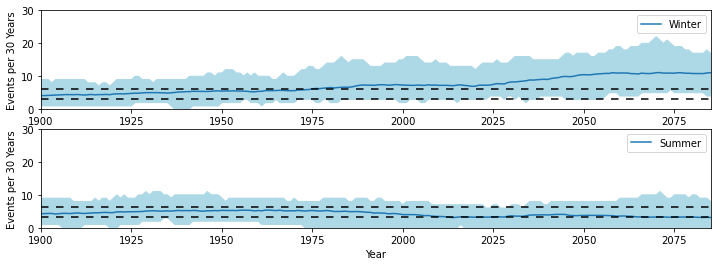

In [51]:
ax=emergePlot(
    compoundCountsXr.sel(fire='pos',experiment='ssp585',drop=True),
    compoundCountsXr.sel(fire='pos',experiment='piControl',drop=True),
    xlim=[1900,2085]
)
plt.xlabel('Year')

ax[0].legend(['Winter'])
ax[1].legend(['Summer'])

ax[0].set_ylim([0,30])
ax[1].set_ylim([0,30])



(0.0, 20.0)

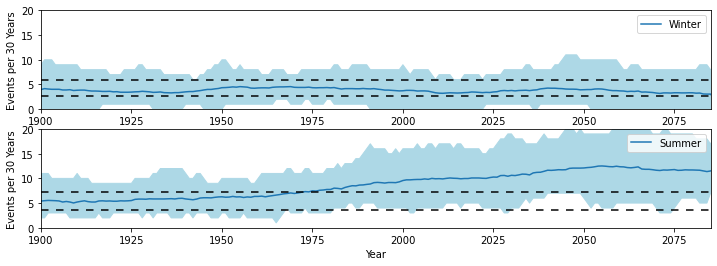

In [52]:
ax=emergePlot(
    compoundCountsXr.sel(fire='neg',experiment='ssp585',drop=True),
    compoundCountsXr.sel(fire='neg',experiment='piControl',drop=True)
)
plt.xlabel('Year')


ax[0].legend(['Winter'])
ax[1].legend(['Summer'])
ax[0].set_xlim([1900,2085])
ax[1].set_xlim([1900,2085])

ax[0].set_ylim([0,20])
ax[1].set_ylim([0,20])



# Time of emergence - Fire Pos / Dry

Do a plot to show time of emergence.
Using mean/min/max in each interval as the trend, and number of events (95%CI) in piControl as the baseline

In [53]:
indexSet = 'ecCombinedDmiSam'
compounds = [
    'all3','enso+iod','enso+sam','iod+sam'
]
rollingFirePos=firePos.rolling(year=30,min_periods=15,center=True).sum('year')
rollingFireNeg=fireNeg.rolling(year=30,min_periods=15,center=True).sum('year')

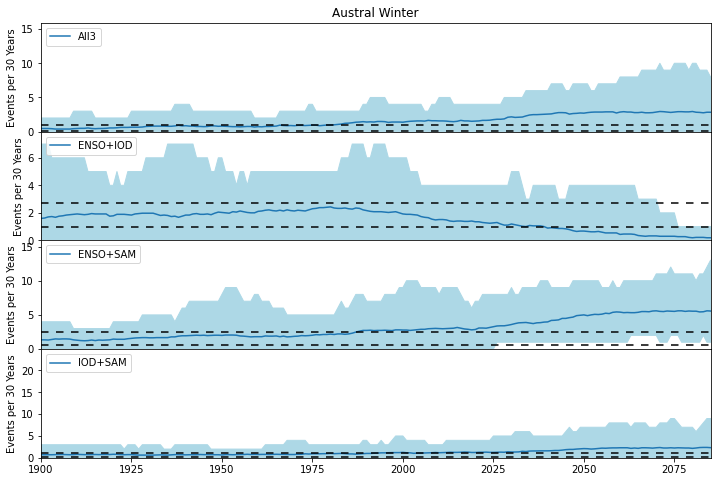

In [54]:
ax=emergePlot(
    rollingFirePos.ecCombinedDmiSamwinter.sel(compound=compounds).to_dataset('compound'), 
    piConPos.ecCombinedDmiSamwinter.sel(compound=compounds).to_dataset('compound').rolling(year=30,min_periods=15,center=True).sum('year'),
    xlim=[1900,2085]
)

ax[0].set_title('Austral Winter')
ax[0].legend(['All3'], loc='upper left')
ax[1].legend(['ENSO+IOD'], loc='upper left')
ax[2].legend(['ENSO+SAM'], loc='upper left')
ax[3].legend(['IOD+SAM'], loc='upper left')

ax[0].set_ylim([0,15.9])
ax[1].set_ylim([0,7.9])
ax[2].set_ylim([0,15.9])
ax[3].set_ylim([0,24.9])

[axx.set_xticklabels([]) for axx in ax[:-1]]

plt.subplots_adjust(hspace=0)




As there is a trend towards SAM dominating, plot how SAM events are compounding the precvioudly ENSO/IOD only to create a greater impact.

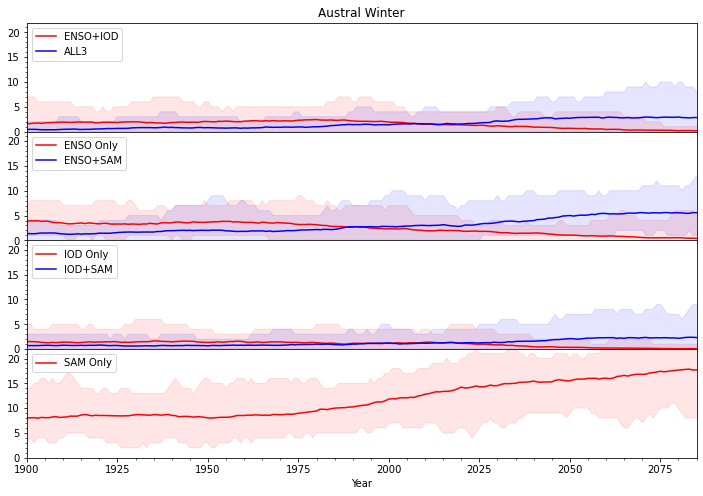

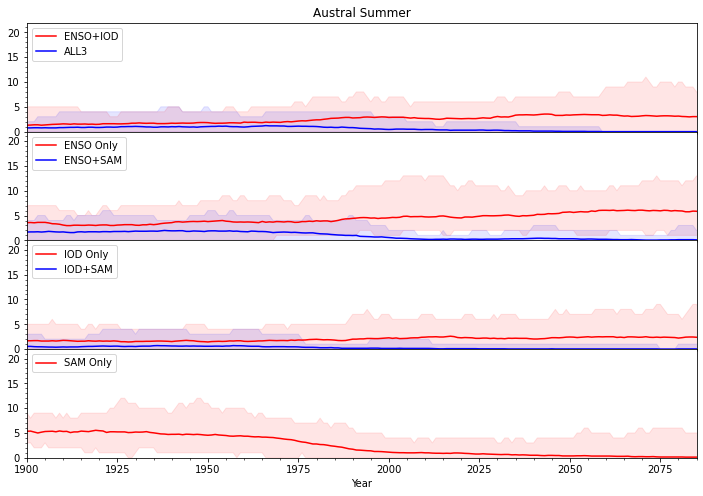

In [55]:
for iSeason in ['winter','summer']:
    plt.figure(figsize=(12,8))
    axx=list()
    iPlot=1
    for indexPair in [
        ['enso+iod','all3'],
        ['enso','enso+sam'],
        ['iod','iod+sam'],
        ['sam']
    ]:
        axx.append(plt.subplot(4,1,iPlot))
        overlaidEmergePlot(
            rollingFirePos[indexSet+iSeason].sel(
                compound=indexPair
            ).to_dataset('compound')
        )
        plt.ylabel('')
        plt.xlim([1900,2085])
        plt.ylim([0,21.9])
        iPlot=iPlot+1

    plt.subplots_adjust(hspace=0)
    axx[0].set_title('Austral '+iSeason.capitalize())

    [ax.set_xticklabels([]) for ax in axx[:-1]]

    axx[0].legend(['ENSO+IOD','ALL3'], loc='upper left')
    axx[1].legend(['ENSO Only','ENSO+SAM'], loc='upper left')
    axx[2].legend(['IOD Only','IOD+SAM'], loc='upper left')
    axx[3].legend(['SAM Only'], loc='upper left')



# Time of Emergence - Fire Neg / Wet

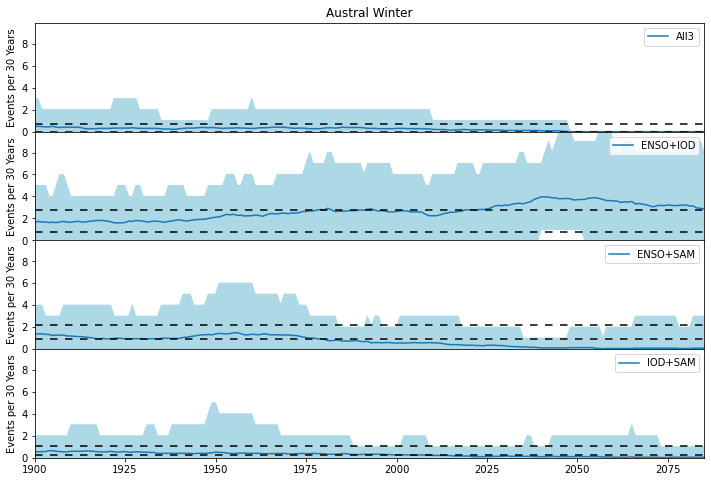

In [56]:
ax=emergePlot(
    fireNeg.ecCombinedDmiSamwinter.sel(compound=compounds).to_dataset('compound').rolling(year=30,min_periods=15,center=True).sum('year'), 
    piConNeg.ecCombinedDmiSamwinter.sel(compound=compounds).to_dataset('compound').rolling(year=30,min_periods=15,center=True).sum('year'),
    xlim=[1900,2085]
)

ax[0].set_title('Austral Winter')
ax[0].legend(['All3'])
ax[1].legend(['ENSO+IOD'])
ax[2].legend(['ENSO+SAM'])
ax[3].legend(['IOD+SAM'])

[axx.set_ylim([0,9.9]) for axx in ax]
[axx.set_xticklabels([]) for axx in ax[:-1]]

plt.subplots_adjust(hspace=0)




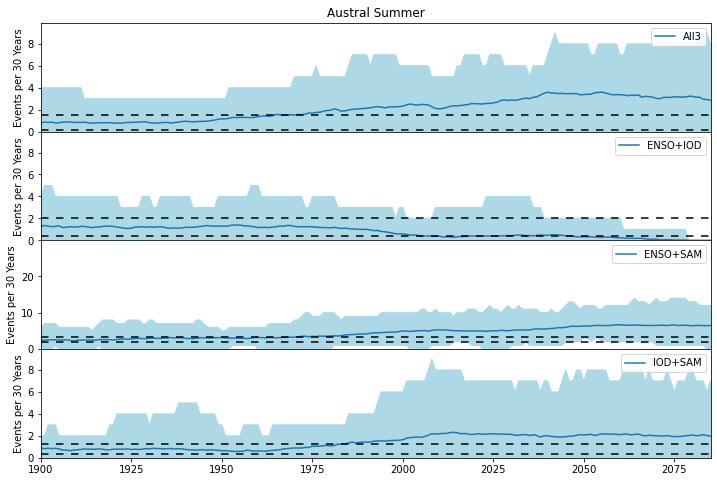

In [57]:
ax=emergePlot(
    fireNeg.ecCombinedDmiSamsummer.sel(compound=compounds).to_dataset('compound').rolling(year=30,min_periods=15,center=True).sum('year'), 
    piConNeg.ecCombinedDmiSamsummer.sel(compound=compounds).to_dataset('compound').rolling(year=30,min_periods=15,center=True).sum('year'),
    xlim=[1900,2085]
)

ax[0].set_title('Austral Summer')
ax[0].legend(['All3'])
ax[1].legend(['ENSO+IOD'])
ax[2].legend(['ENSO+SAM'])
ax[3].legend(['IOD+SAM'])

[axx.set_ylim([0,9.9]) for axx in ax]
ax[2].set_ylim([0,29.9])
[axx.set_xticklabels([]) for axx in ax[:-1]]

plt.subplots_adjust(hspace=0)




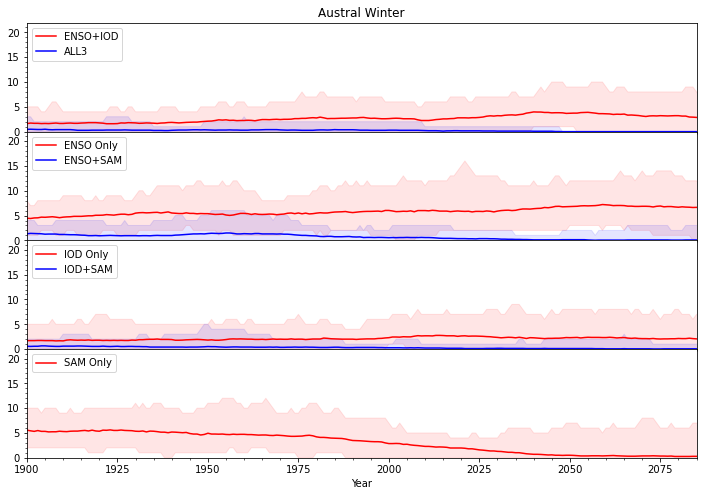

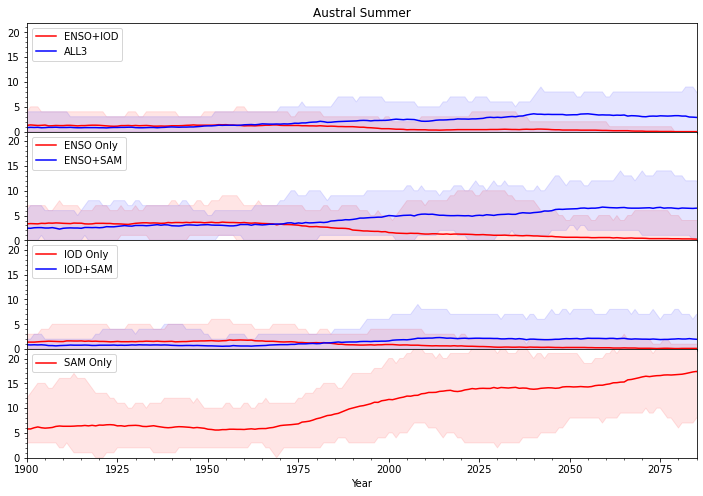

In [58]:
for iSeason in ['winter','summer']:
    plt.figure(figsize=(12,8))
    axx=list()
    iPlot=1
    for indexPair in [
        ['enso+iod','all3'],
        ['enso','enso+sam'],
        ['iod','iod+sam'],
        ['sam']
    ]:
        axx.append(plt.subplot(4,1,iPlot))
        overlaidEmergePlot(
            rollingFireNeg[indexSet+iSeason].sel(
                compound=indexPair
            ).to_dataset('compound')
        )
        plt.ylabel('')
        plt.xlim([1900,2085])
        plt.ylim([0,21.9])
        iPlot=iPlot+1

    plt.subplots_adjust(hspace=0)
    axx[0].set_title('Austral '+iSeason.capitalize())

    [ax.set_xticklabels([]) for ax in axx[:-1]]

    axx[0].legend(['ENSO+IOD','ALL3'], loc='upper left')
    axx[1].legend(['ENSO Only','ENSO+SAM'], loc='upper left')
    axx[2].legend(['IOD Only','IOD+SAM'], loc='upper left')
    axx[3].legend(['SAM Only'], loc='upper left')



# Index comparisons - ENSO E vs C

all enso


(0.0, 20.0)

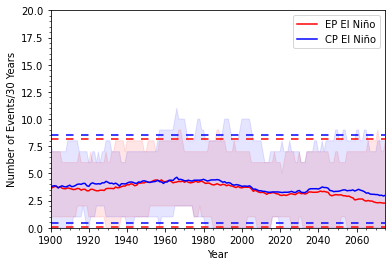

In [61]:
print('all enso')
overlaidEmergePlot(
        firePos[[
            'eIndexDmiSamwinter','cIndexDmiSamwinter'
               ]].sel(compound=['enso','enso+iod','all3']).any('compound').rolling(year=30,min_periods=15,center=True).sum('year'), 
        piConPos[[
            'eIndexDmiSamwinter','cIndexDmiSamwinter'
                ]].sel(compound=['enso','enso+iod','all3']).any('compound').where(piConPos.eIndexDmiSamsummer.isnull()==False).rolling(year=30,min_periods=15,center=True).sum('year') 
)
plt.legend(['EP El Niño', '_no_','_no_', 'CP El Niño'])
#plt.legend(['El Niño+East IO','El Niño+DMI'])
plt.xlim([1900,2075])
plt.ylim([0,20])


not compound enso


(0.0, 20.0)

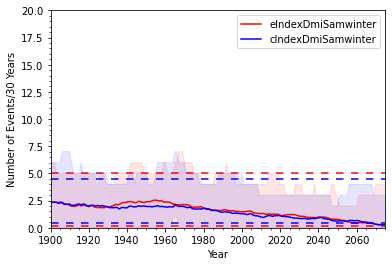

In [62]:
print('not compound enso')
overlaidEmergePlot(
        firePos[[
            'eIndexDmiSamwinter','cIndexDmiSamwinter'
               ]].sel(compound=['enso']).any('compound').rolling(year=30,min_periods=15,center=True).sum('year'), 
        piConPos[[
            'eIndexDmiSamwinter','cIndexDmiSamwinter'
                ]].sel(compound=['enso']).any('compound').where(piConPos.eIndexDmiSamsummer.isnull()==False).rolling(year=30,min_periods=15,center=True).sum('year') 
)
plt.legend()
#plt.legend(['El Niño+East IO','El Niño+DMI'])
plt.xlim([1900,2075])
plt.ylim([0,20])


# Impacts

Fire:pos
winter


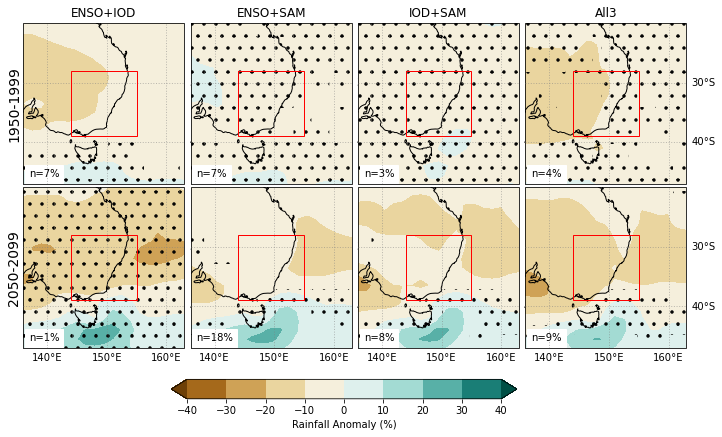

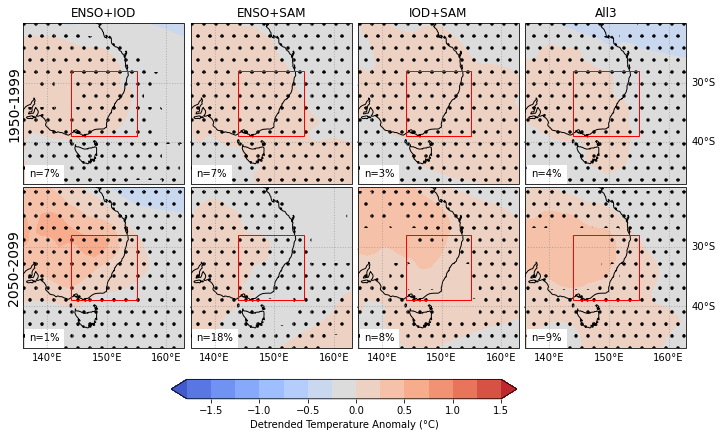

summer


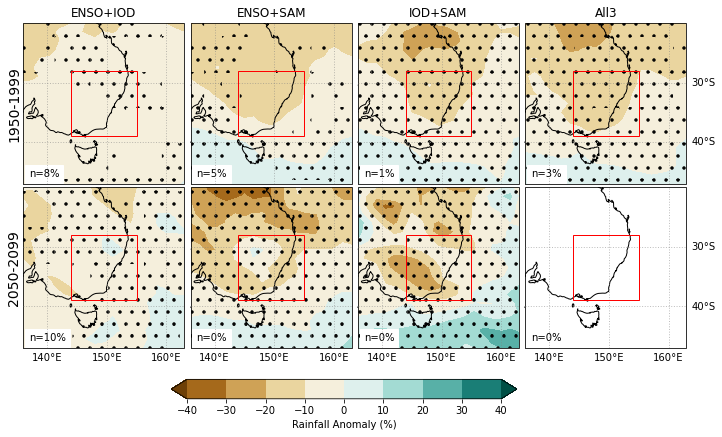

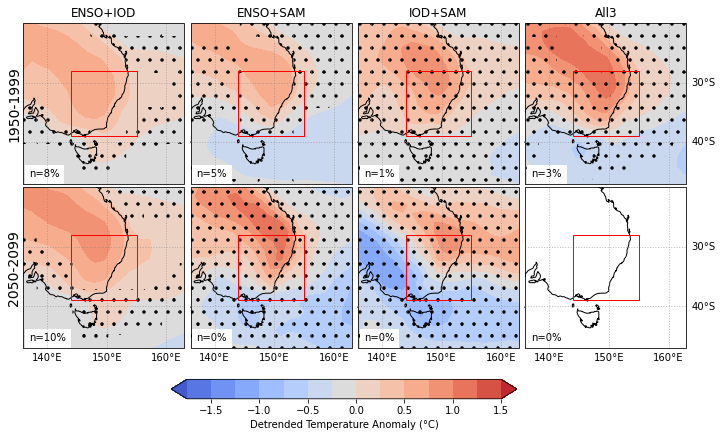

Fire:neg
winter


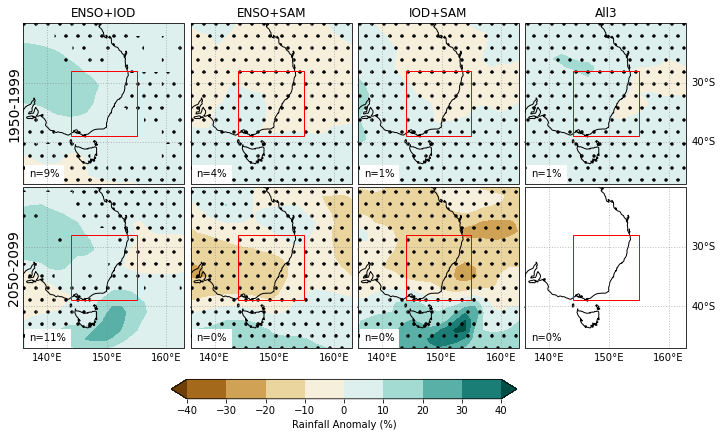

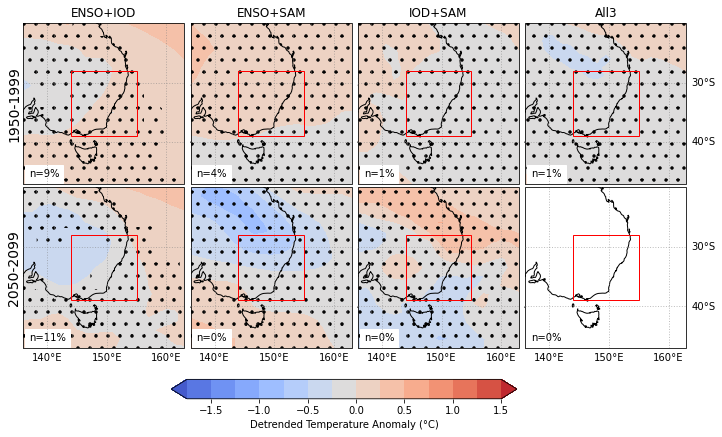

summer


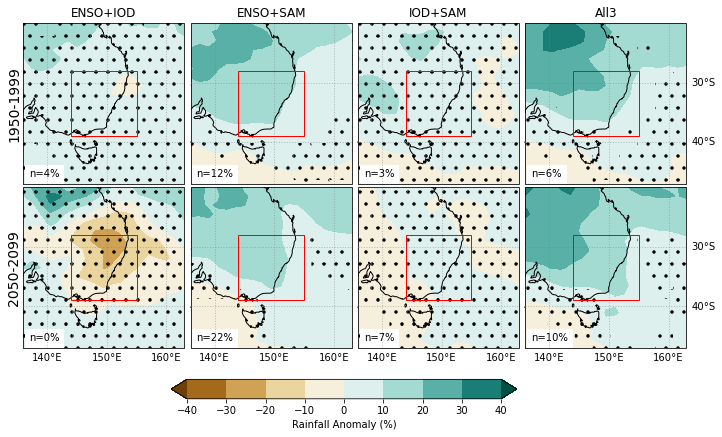

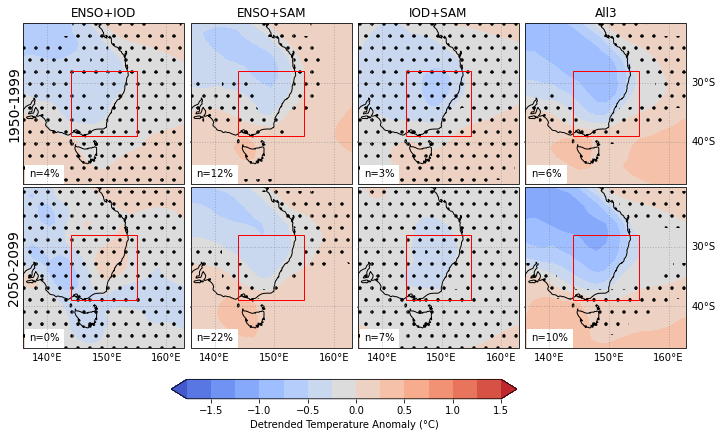

In [71]:
%run helpers/impactPlots.ipynb
for iFire in ['pos','neg']:
    print('Fire:'+iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)
        axs=multiPlotter(
            prXr[iSeason.capitalize()+' Rain'], #sourceData
            allCompoundsXr[indexSet+iSeason].to_dataset('compound').sel(fire=iFire, experiment='ssp585', drop=True), #masks for event types
            eventsList, #names of event types
            cbarLabel='Rainfall Anomaly (%)'
        )
        axs[0].set_title('ENSO+IOD')
        axs[1].set_title('ENSO+SAM')
        axs[2].set_title('IOD+SAM')
        axs[3].set_title('All3')
        plt.show()
        
        axs=multiPlotter(
            detrendTsXr[iSeason.capitalize()+' Temp'],
            allCompoundsXr[indexSet+iSeason].to_dataset('compound').sel(fire=iFire, experiment='ssp585', drop=True), 
            eventsList,
            cbarLabel='Detrended Temperature Anomaly (°C)'
        )
        axs[0].set_title('ENSO+IOD')
        axs[1].set_title('ENSO+SAM')
        axs[2].set_title('IOD+SAM')
        axs[3].set_title('All3')
        plt.show()

# ENSO comparisons

pos
winter


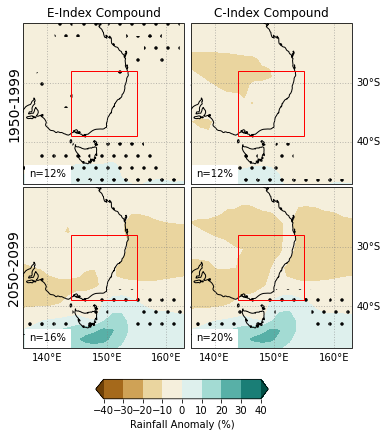

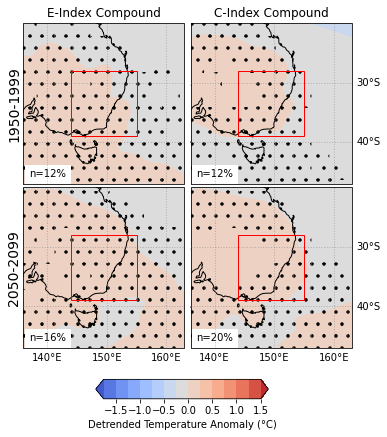

summer


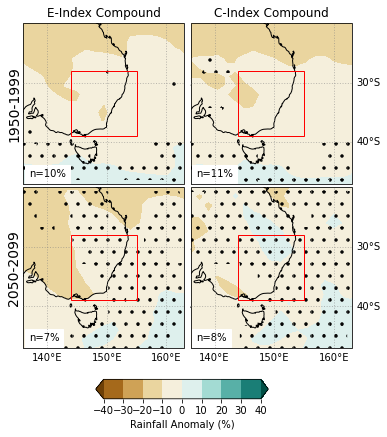

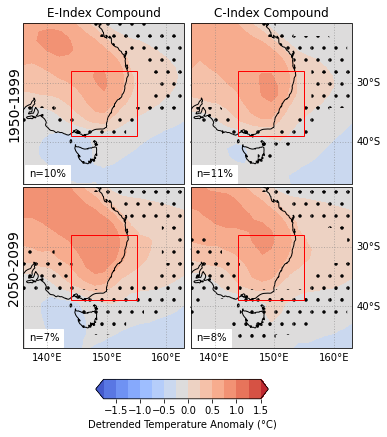

neg
winter


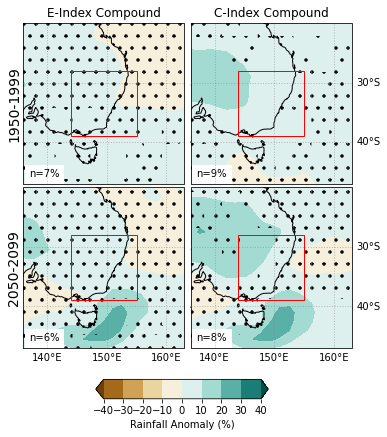

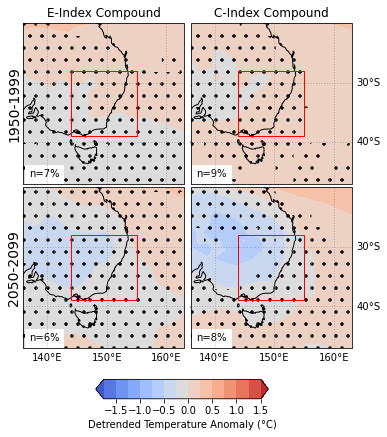

summer


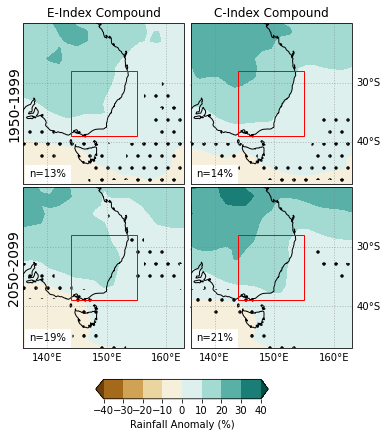

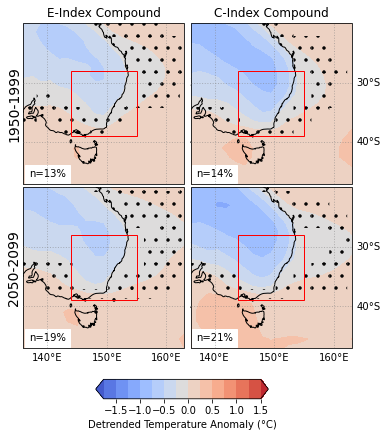

In [75]:
%run helpers/impactPlots.ipynb
for iFire in ['pos','neg']:
    print(iFire)
    for iSeason in ['winter','summer']:
            print(iSeason)

            axs=multiPlotter(
                prXr[iSeason.capitalize()+' Rain'], #sourceData
                allCompoundsXr[
                    ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason]
                ].sel(fire=iFire,compound=['enso+iod','enso+sam','all3'],experiment='ssp585',drop=True).any('compound'), #masks for event types
                ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason],
                cbarLabel='Rainfall Anomaly (%)'
            )
            axs[0].set_title('E-Index Compound')
            axs[1].set_title('C-Index Compound')


            plt.show()

            axs=multiPlotter(
                detrendTsXr[iSeason.capitalize()+' Temp'], #sourceData
                allCompoundsXr[
                    ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason]
                ].sel(fire=iFire,compound=['enso+iod','enso+sam','all3'],experiment='ssp585',drop=True).any('compound'), #masks for event types
                ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason],
                cbarLabel='Detrended Temperature Anomaly (°C)'
            )
            axs[0].set_title('E-Index Compound')
            axs[1].set_title('C-Index Compound')

            plt.show()


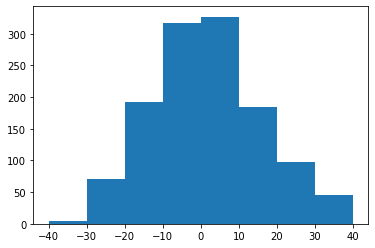

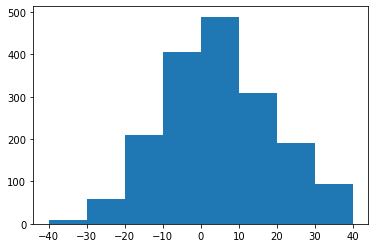

In [82]:

import numpy as np
for iFire in ['pos','neg']:
    eventAnoms=domain(prXr[iSeason.capitalize()+' Rain'].where(
                            allCompoundsXr['ecCombinedDmiSam'+iSeason].sel(
                                compound=['enso+iod','enso+sam','iod+sam','all3'],
                                year=slice(2050,2099),
                                fire=iFire,
                                drop=True
                                ).any('compound')
                            )
                        ).mean(['lat','lon'])

    n=plt.hist(
        eventAnoms.values.flatten(),
        bins=[-40,-30,-20,-10,0,10,20,30,40]
    )
    
    plt.show()

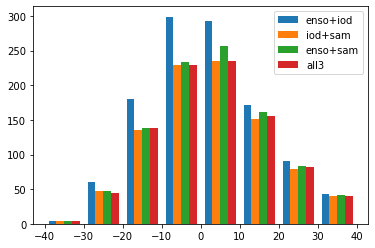

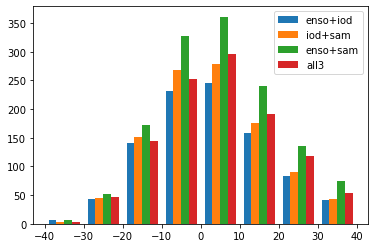

In [85]:
compounds=['enso+iod','iod+sam','enso+sam','all3']
import numpy as np
for iFire in ['pos','neg']:
    eventAnoms=domain(prXr[iSeason.capitalize()+' Rain'].where(
                            allCompoundsXr['ecCombinedDmiSam'+iSeason].sel(
                                compound=compounds,
                                year=slice(2050,2099),
                                fire=iFire,
                                drop=True
                                )
                            )
                        ).to_dataset('compound').mean(['lat','lon'])

    n=plt.hist(
        [eventAnoms[iIndex].values.flatten() for iIndex in compounds],
        bins=[-40,-30,-20,-10,0,10,20,30,40]
    )
    
    plt.legend(compounds)
    plt.show()

winterPos


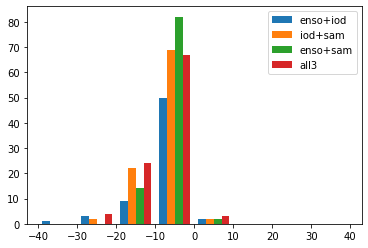

summerPos


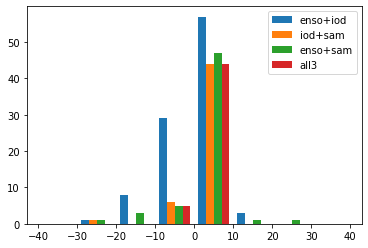

winterNeg


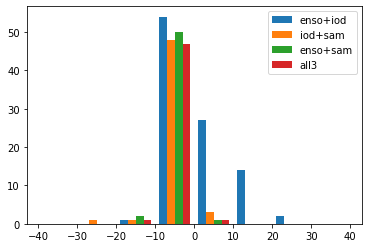

summerNeg


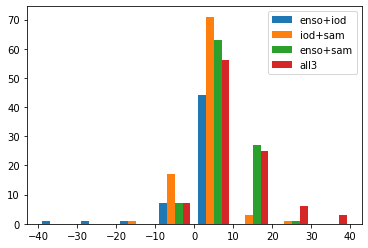

In [84]:
compounds=['enso+iod','iod+sam','enso+sam','all3']
import numpy as np
for iFire in ['pos','neg']:
    for iSeason in ['winter','summer']:
        print(iSeason+iFire.capitalize())
        eventAnoms=domain(prXr[iSeason.capitalize()+' Rain'].where(
                                allCompoundsXr['ecCombinedDmiSam'+iSeason].sel(
                                    compound=compounds,
                                    year=slice(2050,2099),
                                    fire=iFire,
                                    drop=True
                                    )
                                )
                            ).to_dataset('compound').mean(['model','lat','lon'])

        n=plt.hist(
            [eventAnoms[iIndex].values.flatten() for iIndex in compounds],
            bins=[-40,-30,-20,-10,0,10,20,30,40]
        )

        plt.legend(compounds)
        plt.show()

In [94]:
eventAnoms['enso+iod'].values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

winterPos


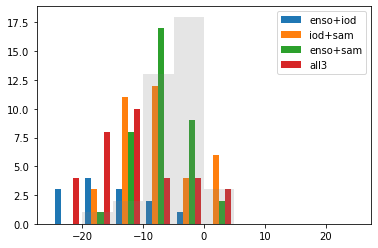

summerPos


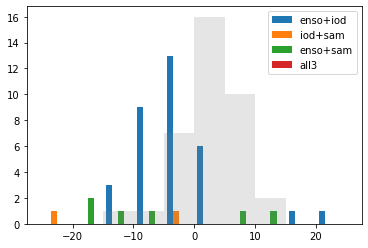

winterNeg


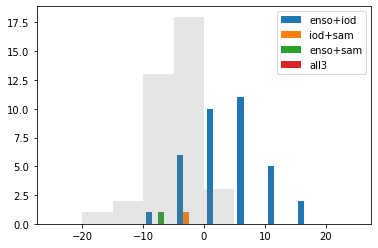

summerNeg


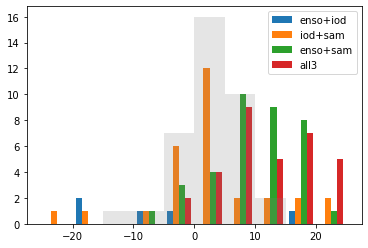

In [96]:
compounds=['enso+iod','iod+sam','enso+sam','all3']
import numpy as np
for iFire in ['pos','neg']:
    for iSeason in ['winter','summer']:
        print(iSeason+iFire.capitalize())
        eventAnoms=domain(prXr[iSeason.capitalize()+' Rain'].where(
                                allCompoundsXr['ecCombinedDmiSam'+iSeason].sel(
                                    compound=compounds,
                                    experiment='ssp585',
                                    year=slice(2050,2099),
                                    fire=iFire,
                                    drop=True
                                    )
                                )
                            ).to_dataset('compound').mean(['year','lat','lon'])

        n=plt.hist(
            [eventAnoms[iIndex].values.flatten() for iIndex in compounds],
            bins=np.arange(-25,26,5)
        )

        plt.legend(compounds)
        
        
        allYears=domain(
            prXr[iSeason.capitalize()+' Rain'].sel(year=slice(2050,2099))
        ).mean(['year','lat','lon'])
        
        n=plt.hist(
            allYears.values.flatten(),
            bins=np.arange(-25,26,5), 
            alpha=0.2,
            color='grey'
        )
        
        plt.show()